In [237]:
%matplotlib notebook

In [238]:
%matplotlib inline

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
import importlib
from IPython.display import clear_output
from astropy.time import Time

In [240]:
sys.path.append("/Users/jrobinson/atlas-phase-curves/atlas-phase-curves")
# sys.path.append("/home/jer/atlas-phase-curves/atlas-phase-curves")
from calculate_phase import atlas_SQL_query_df
from calculate_phase import atlas_database_connection as adb
from calculate_phase import solar_apparitions as sa

In [241]:
importlib.reload(atlas_SQL_query_df)

<module 'calculate_phase.atlas_SQL_query_df' from '/Users/jrobinson/atlas-phase-curves/atlas-phase-curves/calculate_phase/atlas_SQL_query_df.py'>

In [296]:
cnx=adb.database_connection().connect()
cursor = cnx.cursor()

In [243]:
qry = "SHOW TABLES;"
pd.read_sql_query(qry,cnx)

,Tables_in_atlas_moving_objects
0,NEO_select
1,atlas_exposures
2,atlas_objects
3,atlas_phase_fits
4,day_tracker
5,dophot_photometry
6,mba_select
7,orbfit_positions
8,orbital_elements
9,phase_curve_parameters_c


In [244]:
qry = """select *
    from INFORMATION_SCHEMA.COLUMNS
    where TABLE_NAME='atlas_exposures'"""
pd.read_sql_query(qry,cnx)

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,COLUMN_NAME,ORDINAL_POSITION,COLUMN_DEFAULT,IS_NULLABLE,DATA_TYPE,CHARACTER_MAXIMUM_LENGTH,CHARACTER_OCTET_LENGTH,...,NUMERIC_SCALE,DATETIME_PRECISION,CHARACTER_SET_NAME,COLLATION_NAME,COLUMN_TYPE,COLUMN_KEY,EXTRA,PRIVILEGES,COLUMN_COMMENT,GENERATION_EXPRESSION
0,def,atlas_moving_objects,atlas_exposures,primaryId,1,None,NO,bigint,NaN,NaN,...,0.0,NaN,None,None,bigint(20),PRI,auto_increment,"select,insert,update,references",An internal counter,
1,def,atlas_moving_objects,atlas_exposures,dateCreated,2,CURRENT_TIMESTAMP,YES,datetime,NaN,NaN,...,NaN,0.0,None,None,datetime,,,"select,insert,update,references",,
2,def,atlas_moving_objects,atlas_exposures,dateLastModified,3,CURRENT_TIMESTAMP,YES,datetime,NaN,NaN,...,NaN,0.0,None,None,datetime,,,"select,insert,update,references",,
3,def,atlas_moving_objects,atlas_exposures,updated,4,0,YES,tinyint,NaN,NaN,...,0.0,NaN,None,None,tinyint(4),,,"select,insert,update,references",,
4,def,atlas_moving_objects,atlas_exposures,atlas_object_id,5,None,YES,varchar,100.0,100.0,...,NaN,NaN,latin1,latin1_swedish_ci,varchar(100),,,"select,insert,update,references",,
5,def,atlas_moving_objects,atlas_exposures,decDeg,6,None,YES,double,NaN,NaN,...,NaN,NaN,None,None,double,,,"select,insert,update,references",,
6,def,atlas_moving_objects,atlas_exposures,exp_time,7,None,YES,double,NaN,NaN,...,NaN,NaN,None,None,double,,,"select,insert,update,references",,
7,def,atlas_moving_objects,atlas_exposures,filter,8,None,YES,varchar,10.0,10.0,...,NaN,NaN,latin1,latin1_swedish_ci,varchar(10),,,"select,insert,update,references",,
8,def,atlas_moving_objects,atlas_exposures,limiting_magnitude,9,None,YES,double,NaN,NaN,...,NaN,NaN,None,None,double,,,"select,insert,update,references",,
9,def,atlas_moving_objects,atlas_exposures,mjd,10,None,YES,double,NaN,NaN,...,NaN,NaN,None,None,double,,,"select,insert,update,references",,


In [245]:
qry = "SELECT COUNT(*) FROM atlas_exposures"
pd.read_sql_query(qry,cnx)

,COUNT(*)
0,2453086


In [246]:
# qry = """SELECT * FROM atlas_exposures"""
# df_exp = pd.read_sql_query(qry,cnx)
# df_exp

In [247]:
# t = Time.now()
# fname = "atlas_exposures_{:.4f}.csv".format(t.mjd)
# df_exp.to_csv(fname)

In [248]:
df_exp = pd.read_csv("atlas_exposures_59788.3936.csv", index_col = 0)

In [275]:
len(df_exp)

2378766

In [249]:
mask_null = np.isnan(df_exp["limiting_magnitude"])
df_lim = df_exp[~mask_null]
df_lim

,primaryId,dateCreated,dateLastModified,updated,atlas_object_id,decDeg,exp_time,filter,limiting_magnitude,mjd,...,expname,htm16ID,htm13ID,htm10ID,pyephem_mjd,pyephem_positions,orbfit_positions,dophot_match,dev_flag,local_data
0,6,2017-10-27 18:02:44,2017-10-30 12:48:50,1,TA112N05,5.45443,30.0,o,18.440001,58016.614791,...,01a58016o0540o,63224569332,987883895,15435685,58016.6,1,1,1,0,0
1,7,2017-10-27 18:02:44,2017-10-30 12:48:50,1,TA107N05,5.39438,30.0,o,18.510000,58016.612473,...,01a58016o0535o,62348560821,974196262,15221816,58016.6,1,1,1,0,0
2,8,2017-10-27 18:02:44,2017-10-30 12:48:50,1,TA112N05,5.39430,30.0,o,18.430000,58016.611072,...,01a58016o0532o,63224587096,987884173,15435690,58016.6,1,1,1,0,0
3,9,2017-10-27 18:02:44,2017-10-30 12:48:50,1,TA117N05,5.45466,30.0,o,18.389999,58016.605816,...,01a58016o0521o,62732064121,980188501,15315445,58016.6,1,1,1,0,0
4,10,2017-10-27 18:02:44,2017-10-30 12:48:50,1,TA112N05,5.43481,30.0,o,18.480000,58016.605358,...,01a58016o0520o,63224668232,987885441,15435710,58016.6,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184581,1970837,2019-08-08 15:29:17,2019-08-08 15:29:17,0,TA313N10,10.15278,30.0,c,19.810000,58692.361930,...,02a58692o0265c,55081301306,860645332,13447583,58692.4,1,1,1,0,0
1184582,1970838,2019-08-08 15:29:17,2019-08-08 15:29:17,0,TA302S00,-0.04793,30.0,c,19.740000,58692.361397,...,02a58692o0264c,47882599424,748165616,11690087,58692.4,1,1,1,0,0
1184583,1970839,2019-08-08 15:29:17,2019-08-08 15:29:17,0,TA318N15,16.00329,30.0,c,19.680000,58692.360802,...,02a58692o0263c,55269547090,863586673,13493541,58692.4,1,1,1,0,0
1184584,1970840,2019-08-08 15:29:17,2019-08-08 15:29:17,0,TA294S21,-21.34798,30.0,c,19.490000,58692.303987,...,02a58692o0148c,48065067269,751016676,11734635,58692.3,1,1,1,0,0


In [250]:
df_atlas = pd.read_csv("atlas_co_exposures.tst", delim_whitespace = True)
df_atlas

,expname,object,ra,dec,mjd,filter,mag5sig,magzpt,qc,focus,...,camid,airmass,seeing,skymag,cloud,cloudrms,moonsky,nn,mangle,sourcefile
0,01a57800o0023o,SATGAL15,94.29499,-3.57453,57800.215184,o,17.46,21.374,2147483647,9472.0,...,acam2,1.213,6.880,18.40,1.008,0.069,21.000,57800,114.226,/atlas/red/01a/57800/01a57800o0023o.fits.fz
1,01a57800o0024o,SATGAL15,94.29482,-3.57469,57800.215718,o,17.55,21.363,2147483647,9472.0,...,acam2,1.211,6.786,18.43,1.005,0.071,21.000,57800,114.234,/atlas/red/01a/57800/01a57800o0024o.fits.fz
2,01a57800o0025o,SATGAL15,94.29479,-3.57474,57800.216255,o,17.62,21.366,2147483647,9472.0,...,acam2,1.209,6.882,18.47,1.006,0.066,21.000,57800,114.242,/atlas/red/01a/57800/01a57800o0025o.fits.fz
3,01a57800o0026o,SATGAL15,94.29468,-3.57478,57800.216777,o,17.74,21.386,2147483647,9472.0,...,acam2,1.207,6.719,18.54,1.005,0.064,21.000,57800,114.250,/atlas/red/01a/57800/01a57800o0026o.fits.fz
4,01a57800o0027o,SATGAL15,94.29472,-3.57477,57800.217284,o,17.76,21.397,2147483647,9472.0,...,acam2,1.205,7.167,18.67,1.007,0.054,21.000,57800,114.257,/atlas/red/01a/57800/01a57800o0027o.fits.fz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511716,01a59808o0783o,SA025N37,25.31821,36.68973,59808.632751,o,18.31,22.202,4,7720.0,...,green+fuzzy+4x,1.068,4.786,18.50,1.000,0.004,19.850,59808,25.346,/atlas/red/01a/59808/01a59808o0783o.fits.fz
2511717,01a59808o0784o,SA014N42,13.63810,41.94203,59808.633249,o,18.10,22.191,4,7718.0,...,green+fuzzy+4x,1.163,5.259,18.36,1.000,0.006,20.035,59808,34.462,/atlas/red/01a/59808/01a59808o0784o.fits.fz
2511718,01a59808o0785o,SA007N42,6.84110,41.94322,59808.633707,o,18.11,22.190,4,7721.0,...,green+fuzzy+4x,1.220,4.952,18.21,1.000,0.005,20.082,59808,37.939,/atlas/red/01a/59808/01a59808o0785o.fits.fz
2511719,01a59808o0786o,SA064N16,64.50666,15.67416,59808.634436,o,17.74,22.184,4,7722.0,...,green+fuzzy+4x,1.101,4.767,17.72,1.000,0.014,19.927,59808,28.832,/atlas/red/01a/59808/01a59808o0786o.fits.fz


In [251]:
df_atlas[df_atlas["expname"]=="01a58016o0492o"].iloc[0]

expname                                    01a58016o0492o
object                                           TA117N05
ra                                              117.18001
dec                                               5.43442
mjd                                          58016.592191
filter                                                  o
mag5sig                                              18.4
magzpt                                             22.218
qc                                             2147483647
focus                                              7780.0
dettem                                            -234.92
bckgnd_adu                                            837
fwhm_px                                            4.5373
nstar                                             69296.0
status                                                  R
exptime                                                30
pa_deg                                              0.227
camid         

In [252]:
df_atlas[df_atlas["expname"]=="02a59002o0354o"].iloc[0]

expname                                    02a59002o0354o
object                                           SL255S16
ra                                              254.58262
dec                                             -15.74054
mjd                                          59002.418667
filter                                                  o
mag5sig                                             18.96
magzpt                                             22.145
qc                                                      0
focus                                             10530.0
dettem                                             -53.39
bckgnd_adu                                           1214
fwhm_px                                            2.0531
nstar                                             59802.0
status                                                  R
exptime                                                30
pa_deg                                           -179.989
camid         

In [253]:
# np.isin is very slow for large lists of strings
# set up a subset of each dataframe to compare

_df1=df_lim[["expname","limiting_magnitude"]].copy()

_df2=df_atlas[["expname","mag5sig"]].copy()

# _df1 = _df1.iloc[:10000]
# _df2 = _df2.iloc[:10000]

# create a dataframe that contains all unique names, and the dataframe that they occur in
df_merge = _df1.merge(_df2,on="expname")
df_merge["mjd"] = [int(x[3:8]) for x in df_merge["expname"]]
df_merge

,expname,limiting_magnitude,mag5sig,mjd
0,01a58016o0540o,18.440001,18.70,58016
1,01a58016o0535o,18.510000,18.82,58016
2,01a58016o0532o,18.430000,18.75,58016
3,01a58016o0521o,18.389999,18.69,58016
4,01a58016o0520o,18.480000,18.79,58016
...,...,...,...,...
761712,02a58692o0265c,19.810000,19.82,58692
761713,02a58692o0264c,19.740000,19.74,58692
761714,02a58692o0263c,19.680000,19.71,58692
761715,02a58692o0148c,19.490000,19.51,58692


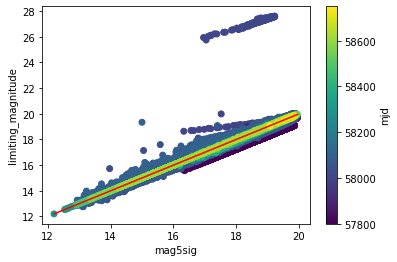

In [254]:
x_plot = "mag5sig"
y_plot = "limiting_magnitude"
c_plot = "mjd"
df_plot = df_merge


fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])


s1 = ax1.scatter(df_plot[x_plot],df_plot[y_plot], c = df_plot[c_plot])
cbar1 = fig.colorbar(s1)
cbar1.set_label(c_plot)

ax1.plot([np.amin(df_plot[x_plot]),np.amax(df_plot[x_plot])],
        [np.amin(df_plot[x_plot]),np.amax(df_plot[x_plot])], c="r")

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.show()

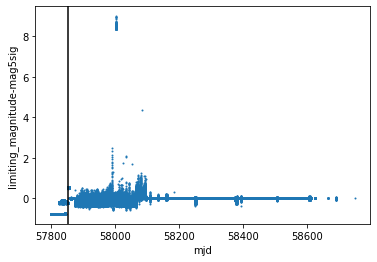

In [255]:
x_plot = "mjd"
y_plot1 = "mag5sig"
y_plot2 = "limiting_magnitude"
df_plot = df_merge

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

s1 = ax1.scatter(df_plot[x_plot],df_plot[y_plot2]-df_plot[y_plot1],s=1)

ax1.axvline(57855,c="k")

ax1.set_xlabel(x_plot)
ax1.set_ylabel("{}-{}".format(y_plot2,y_plot1))

plt.show()

In [213]:
# qry = """SELECT primaryId,dateCreated,dateLastModified,mjd,expname FROM atlas_exposures WHERE limiting_magnitude is null"""
# df_null = pd.read_sql_query(qry,cnx)
df_null = df_exp[mask_null]
df_null

,primaryId,dateCreated,dateLastModified,updated,atlas_object_id,decDeg,exp_time,filter,limiting_magnitude,mjd,...,expname,htm16ID,htm13ID,htm10ID,pyephem_mjd,pyephem_positions,orbfit_positions,dophot_match,dev_flag,local_data
390375,390381,2017-11-16 14:40:53,2017-11-16 14:40:53,1,TA166N42,42.12835,30.0,o,NaN,57844.427222,...,01a57844o0359o,63932059715,998938433,15608413,57844.4,1,1,1,1,0
390376,390382,2017-11-16 14:40:53,2017-11-16 14:40:53,0,TA167N37,37.07846,30.0,o,NaN,57844.393831,...,01a57844o0302o,63925108396,998829818,15606715,57844.4,1,1,1,1,0
390377,390383,2017-11-16 14:40:53,2017-11-16 14:40:53,0,TA180N17,17.02251,30.0,o,NaN,57844.437315,...,01a57844o0375o,60205694400,940713975,14698655,57844.4,1,1,1,1,0
390378,390384,2017-11-16 14:40:53,2017-11-16 14:40:53,0,TA226N17,16.99444,30.0,o,NaN,57844.622836,...,01a57844o0705o,59591925261,931123832,14548809,57844.6,1,1,1,1,0
390379,390385,2017-11-16 14:40:53,2017-11-16 14:40:53,0,TA116N37,37.13711,30.0,o,NaN,57844.259769,...,01a57844o0071o,63439216194,991237753,15488089,57844.3,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2378761,3473550,2022-07-27 12:19:57,2022-07-27 12:19:57,0,SL166N05,5.27832,30.0,o,NaN,59607.535625,...,02a59607o0731o,60316182651,942440353,14725630,59607.5,1,0,0,0,1
2378762,3473551,2022-07-27 12:19:57,2022-07-27 12:19:57,0,SY207N19,18.65021,30.0,o,NaN,59607.532535,...,01a59607o0714o,58323525936,911305092,14239142,59607.5,1,0,0,0,1
2378763,3473552,2022-07-27 12:19:57,2022-07-27 12:19:57,0,SL203N10,10.46843,30.0,o,NaN,59607.586933,...,02a59607o0838o,58941173496,920955835,14389934,59607.6,1,0,0,0,1
2378764,3473553,2022-07-27 12:19:57,2022-07-27 12:19:57,0,SL066N00,0.00448,30.0,o,NaN,59607.275509,...,02a59607o0173o,65030986043,1016109156,15876705,59607.3,1,0,0,0,1


In [214]:
df_null[df_null["expname"]=="01a57844o0397o"]

,primaryId,dateCreated,dateLastModified,updated,atlas_object_id,decDeg,exp_time,filter,limiting_magnitude,mjd,...,expname,htm16ID,htm13ID,htm10ID,pyephem_mjd,pyephem_positions,orbfit_positions,dophot_match,dev_flag,local_data
391124,391130,2017-11-16 14:40:54,2017-11-16 14:40:53,0,TA186N37,37.07912,30.0,o,NaN,57844.450197,...,01a57844o0397o,58571971868,915187060,14299797,57844.5,1,1,1,1,0


In [215]:
df_atlas[df_atlas["expname"]=="01a57844o0397o"]

,expname,object,ra,dec,mjd,filter,mag5sig,magzpt,qc,focus,...,camid,airmass,seeing,skymag,cloud,cloudrms,moonsky,nn,mangle,sourcefile
52095,01a57844o0397o,TA186N37,185.25687,37.07912,57844.450212,o,19.1,21.478,2147483647,10691.0,...,acam2,1.065,7.147,21.21,1.017,0.07,21.0,57844,99.352,/atlas/red/01a/57844/01a57844o0397o.fits.fz


In [216]:
# for i in np.arange(391125,400000,1):
#     try:
#         print(df_null.loc[i])
#         break
#     except:
#         continue

In [217]:
df_atlas[df_atlas["expname"]=="02a59639o0244c"].iloc[0]["mag5sig"]

19.74

In [256]:
# reselect the exposures where limiting magnitude is null when rerun
# This way we don't reupdate exposures which are already fixed
qry = """SELECT expname FROM atlas_exposures where limiting_magnitude is null"""
df_null = pd.read_sql_query(qry,cnx)
df_null

,expname
0,01a57851o0638o
1,01a57851o0547o
2,01a57851o0724o
3,01a57851o0716o
4,01a57851o0663o
...,...
94952,02a59653o0650o
94953,02a59653o0654o
94954,02a59653o0615o
94955,02a59653o0653o


In [257]:
df_null[df_null["expname"]=="01a57844o0359o"]

,expname


In [258]:
len(df_atlas)

2511721

In [259]:
# combine the two sources of exposure names
_df1=df_null[["expname"]].copy()
_df1["df"] = "rockAtlas NULL"

_df2=df_atlas[["expname"]].copy()
_df2["df"] = "atlas"
              
_df = pd.concat([_df1,_df2])
_df

,expname,df
0,01a57851o0638o,rockAtlas NULL
1,01a57851o0547o,rockAtlas NULL
2,01a57851o0724o,rockAtlas NULL
3,01a57851o0716o,rockAtlas NULL
4,01a57851o0663o,rockAtlas NULL
...,...,...
2511716,01a59808o0783o,atlas
2511717,01a59808o0784o,atlas
2511718,01a59808o0785o,atlas
2511719,01a59808o0786o,atlas


In [260]:
# these exposures are null in rockAtlas and not available in atlas co exposures
df_missing = _df[_df["df"]=="rockAtlas NULL"]
df_missing

,expname,df
0,01a57851o0638o,rockAtlas NULL
1,01a57851o0547o,rockAtlas NULL
2,01a57851o0724o,rockAtlas NULL
3,01a57851o0716o,rockAtlas NULL
4,01a57851o0663o,rockAtlas NULL
...,...,...
94952,02a59653o0650o,rockAtlas NULL
94953,02a59653o0654o,rockAtlas NULL
94954,02a59653o0615o,rockAtlas NULL
94955,02a59653o0653o,rockAtlas NULL


In [261]:
df_missing[df_missing["expname"]=="01a57844o0359o"]

,expname,df


In [262]:
# keep only the rows that are duplicates, i.e. the exposure names that are in null list AND present in df_atlas
_df_search = _df[_df.duplicated(['expname'], keep=False)]
_df_search

,expname,df


In [263]:
_df_search[_df_search["expname"]=="01a57800o0484o"]

,expname,df


In [264]:
df_search = _df_search[_df_search["df"]=="rockAtlas NULL"]
df_search

,expname,df


In [265]:
df_atlas[df_atlas["expname"]=="01a57851o0638o"]

,expname,object,ra,dec,mjd,filter,mag5sig,magzpt,qc,focus,...,camid,airmass,seeing,skymag,cloud,cloudrms,moonsky,nn,mangle,sourcefile


In [266]:
from IPython.display import clear_output

In [267]:
# df = df_search

# for i in range(len(df)):
        
# #     if i>20:
# #         break
            
#     expname = df.iloc[i]["expname"]
    
#     try:
#         mag5sig = df_atlas[df_atlas["expname"]==expname].iloc[0]["mag5sig"]
#     except:
#         print("{}, {} mag5sig not found".format(i,expname), end='\r')
#         continue

#     qry = """UPDATE atlas_exposures
#             SET limiting_magnitude={}
#             WHERE expname='{}'""".format(mag5sig,expname)

#     print(i, qry, end='\r')

#     cursor.execute(qry)
#     cnx.commit()

#     clear_output(wait=True)

# search for the remaining missing exposures on db1/db4
See the script read_atlas_data_files.py

In [268]:
# load the list of exposures that we were able to find datafiles for
fname1 = "rockAtlas_missing_exposures_59782.376.csv"
df_found1 = pd.read_csv(fname1, index_col = None)

# add the files we missed before
fname2 = "rockAtlas_missing_exposures_59786.425.csv"
df_found2 = pd.read_csv(fname2, index_col = None)

df_found = pd.concat([df_found1,df_found2])

In [269]:
df_found

,OBS,MJD,MAG5SIG
0,01a57844o0359o,57844.427247,19.03
1,01a57844o0302o,57844.393853,19.17
2,01a57844o0375o,57844.437328,19.03
3,01a57844o0705o,57844.622864,18.98
4,01a57844o0071o,57844.259791,18.96
...,...,...,...
608,02a58011o0140o,58011.303533,17.02
609,01a58012o0176o,58012.293830,17.91
610,01a58012o0162o,58012.287217,17.91
611,01a58012o0154o,58012.283444,17.90


In [270]:
# combine the two sources of exposure names
_df1=df_missing[["expname"]].copy()
_df1["df"] = "rockAtlas NULL"

_df2=df_found[["OBS"]].copy()
_df2 = _df2.rename({"OBS":"expname"},axis=1)
_df2["df"] = "db1/db4"
              
_df = pd.concat([_df1,_df2])
_df

,expname,df
0,01a57851o0638o,rockAtlas NULL
1,01a57851o0547o,rockAtlas NULL
2,01a57851o0724o,rockAtlas NULL
3,01a57851o0716o,rockAtlas NULL
4,01a57851o0663o,rockAtlas NULL
...,...,...
608,02a58011o0140o,db1/db4
609,01a58012o0176o,db1/db4
610,01a58012o0162o,db1/db4
611,01a58012o0154o,db1/db4


In [271]:
_df[_df["expname"]=="01a57844o0359o"]

,expname,df
0,01a57844o0359o,db1/db4


In [272]:
# keep only the rows that are duplicates, i.e. the exposure names that are in null list AND present on db1/db4
# we can update these values
df_update = _df[_df.duplicated(['expname'], keep=False)]
df_update

,expname,df
67406,01a58719o0066o,rockAtlas NULL
67409,01a58719o0033o,rockAtlas NULL
67410,01a58719o0049o,rockAtlas NULL
67411,01a58719o0038o,rockAtlas NULL
67413,01a58719o0071o,rockAtlas NULL
...,...,...
113180,01a59229o0205c,db1/db4
113181,01a59229o0074c,db1/db4
113184,01a59229o0151c,db1/db4
113198,01a59229o0015c,db1/db4


In [273]:
df_update[df_update["expname"]=="02a57849o0071o"]

,expname,df


In [274]:
# these exposures are still missing
df_update[df_update["df"]=="rockAtlas NULL"]

,expname,df
67406,01a58719o0066o,rockAtlas NULL
67409,01a58719o0033o,rockAtlas NULL
67410,01a58719o0049o,rockAtlas NULL
67411,01a58719o0038o,rockAtlas NULL
67413,01a58719o0071o,rockAtlas NULL
67414,01a58719o0039o,rockAtlas NULL
67415,01a58719o0064o,rockAtlas NULL
67418,01a58719o0048o,rockAtlas NULL
67420,01a58719o0074o,rockAtlas NULL
67423,01a58719o0076o,rockAtlas NULL


In [153]:
df_found[pd.isnull(df_found["MAG5SIG"])]

,OBS,MJD,MAG5SIG
108647,01a58719o0066o,58719.312032,NaN
108648,01a58719o0033o,58719.296542,NaN
108649,01a58719o0049o,58719.304054,NaN
108650,01a58719o0038o,58719.298889,NaN
108651,01a58719o0071o,58719.314383,NaN
108653,01a58719o0039o,58719.299358,NaN
108654,01a58719o0064o,58719.311092,NaN
108655,01a58719o0048o,58719.303586,NaN
108658,01a58719o0074o,58719.315793,NaN
108660,01a58719o0076o,58719.316733,NaN


In [155]:
# df = df_update[df_update["df"]=="db1/db4"]

# for i in range(len(df)):
        
# #     if i>20:
# #         break
            
#     expname = df.iloc[i]["expname"]
# #     print(i,expname)
    
#     try:
# #         mag5sig = df_atlas[df_atlas["expname"]==expname].iloc[0]["mag5sig"]
#         mag5sig = df_found[df_found["OBS"]==expname].iloc[0]["MAG5SIG"]
#     except:
#         print("{}, {} mag5sig not found".format(i,expname), end='\r')
#         continue
        
#     if np.isnan(mag5sig):
#         continue

#     qry = """UPDATE atlas_exposures
#             SET limiting_magnitude={}
#             WHERE expname='{}'""".format(mag5sig,expname)

#     print(i, qry, end='\r')

#     cursor.execute(qry)
#     cnx.commit()

#     clear_output(wait=True)

781 UPDATE atlas_exposures
            SET limiting_magnitude=19.25


In [278]:
qry = """SELECT primaryId,dateCreated,dateLastModified,mjd,expname,limiting_magnitude FROM atlas_exposures WHERE limiting_magnitude is NOT null"""
df_lim_mag = pd.read_sql_query(qry,cnx)
df_lim_mag

,primaryId,dateCreated,dateLastModified,mjd,expname,limiting_magnitude
0,6,2017-10-27 18:02:44,2017-10-30 12:48:50,58016.614791,01a58016o0540o,18.440001
1,7,2017-10-27 18:02:44,2017-10-30 12:48:50,58016.612473,01a58016o0535o,18.510000
2,8,2017-10-27 18:02:44,2017-10-30 12:48:50,58016.611072,01a58016o0532o,18.430000
3,9,2017-10-27 18:02:44,2017-10-30 12:48:50,58016.605816,01a58016o0521o,18.389999
4,10,2017-10-27 18:02:44,2017-10-30 12:48:50,58016.605358,01a58016o0520o,18.480000
...,...,...,...,...,...,...
2358124,3560632,2022-08-03 01:50:11,2022-08-03 01:50:18,59653.537257,01a59653o0303o,18.710000
2358125,3560633,2022-08-03 01:50:11,2022-08-03 01:50:18,59653.584375,01a59653o0404o,18.720000
2358126,3560634,2022-08-03 01:50:11,2022-08-03 01:50:18,59653.578900,01a59653o0392o,18.740000
2358127,3560635,2022-08-03 01:50:11,2022-08-03 01:50:18,59653.442569,02a59653o0506o,18.830000


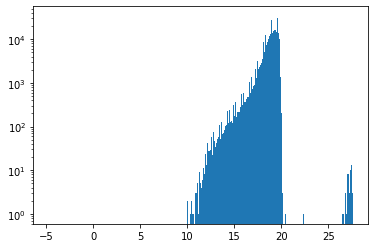

In [281]:
x = plt.hist(df_lim_mag["limiting_magnitude"], bins = "auto", log = True)

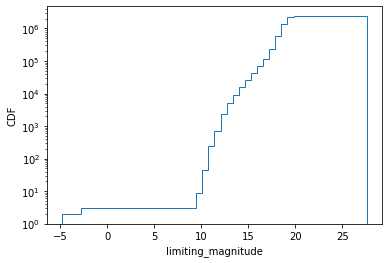

In [283]:
x_plot = "limiting_magnitude"
df_plot = df_lim_mag
bins = 50

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

x=ax1.hist(df_plot[x_plot], density=False, cumulative=True, histtype='step',bins=bins, log= True)

ax1.set_xlabel(x_plot)
ax1.set_ylabel("CDF")

plt.show()

In [285]:
mag_cut = 17.5

In [288]:
# fraction of exposures to be rejected by limiting magnitude cut
len(df_lim_mag[df_lim_mag["limiting_magnitude"]<mag_cut])/len(df_lim_mag)

0.06316660369301255

In [ ]:
# count the number of photometry points cut
df_cut = df_lim_mag[df_lim_mag["limiting_magnitude"]<mag_cut]
phot_count = []

for i in range(len(df_cut)):
    expname = df_cut.iloc[i]["expname"]
    qry = "SELECT COUNT(*) FROM dophot_photometry where expname='{}'".format(expname)
    print(qry)
    df = pd.read_sql_query(qry,cnx)
    n = df.iloc[0]["COUNT(*)"]
    phot_count.append(n)
    
    clear_output(wait=True)

SELECT COUNT(*) FROM dophot_photometry where expname='01a58384o0474o'


In [ ]:
phot_count